# Perform RNA velocity analysis and display results on pre-defined xy coordinates of a SPRING plot.
Most of the code for performing velocyto from here:  
https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb  

Prior to running this notebook, generate .loom files as described here:
http://velocyto.org/velocyto.py/tutorial/index.html

In [1]:
import platform
print(platform.python_version())
import pandas as pd
import json


import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

3.6.7


### Import my utility functions and import statements from github

In [2]:
import os
import datetime

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


## Load per-cell information including coordinates of SPRING plots onto which I want to plot velocyto results

In [5]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
# overwrite to only include cell of interest
cell_mask = (obs['condition'] == 'control').values
obs = obs[cell_mask]
print(obs.shape)
obs.head()

(8594, 25)
(3600, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Initiate a velocyto object

In [6]:
# Create an analysis object
vlm = vcy.VelocytoLoom("data_from_geo/control_loom.loom")
print(vlm.S.shape,len(vlm.ra['Gene']))

(27998, 3600) 27998


In [7]:
# copy and simplify barcode, add to the dictionary "cell/column attribute", accessible as vlm.ca.
# make sure values of this dictionary are np.array, lists won't work and will lead to cryptic errors
# downstream.
print(vlm.ca['CellID'][:3])
vlm.ca['simple_bc'] = np.array([i.strip().split(':')[-1][:-1] for i in vlm.ca['CellID']])
print(vlm.ca['simple_bc'][:3])

['P5_5C_possorted_genome_bam_BWIZ4:AAAGCAATCAGGATCTx'
 'P5_5C_possorted_genome_bam_BWIZ4:AACTGGTCAGGGATTGx'
 'P5_5C_possorted_genome_bam_BWIZ4:AAAGATGCAGGTGCCTx']
['AAAGCAATCAGGATCT' 'AACTGGTCAGGGATTG' 'AAAGATGCAGGTGCCT']


### Deal with different cell/barcode ordering between velocyto (.loom) and cellranger outputs

In [8]:
renamer = {i:i.split('-')[0] for i in obs['barcode']}
olap = np.in1d(vlm.ca['simple_bc'],list(renamer.values()))
print(f'{olap.sum()} out of {len(olap)} barcodes match between cellranger and velocyto outputs')

3600 out of 3600 barcodes match between cellranger and velocyto outputs


In [9]:
# move barcode to index in my obs dataframe
obs.index = [renamer[i] for i in obs['barcode']]
crbcorder = obs.index # cell ranger bc order

# save the original ordering, may need later
obs['cellranger_order'] = np.arange(obs.shape[0])

# reorder obs
obs = obs.loc[vlm.ca['simple_bc']]

In [10]:
# add column attributes
vlm.ca['used_in_spring'] = obs['ctr_epithelial'].astype(bool).values
vlm.ca['spring_x_control'] = obs['x_control'].values
vlm.ca['spring_y_control'] = obs['y_control'].values
vlm.ca['clusters'] = obs['population']

/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


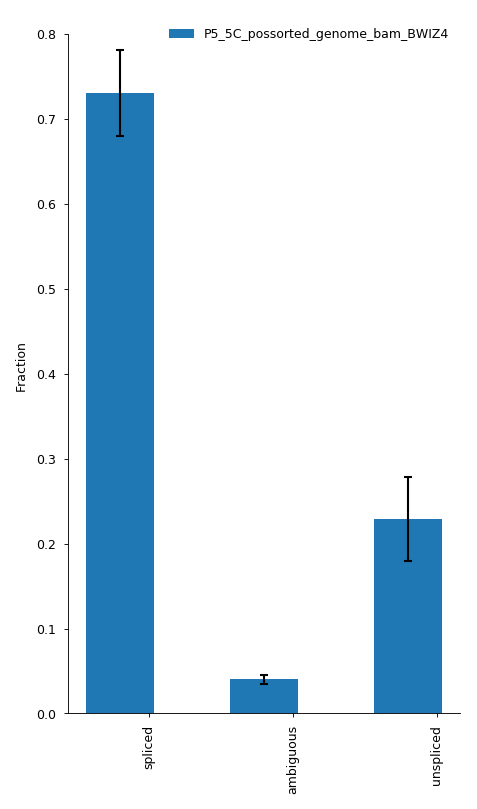

In [11]:
vlm.plot_fractions()
plt.xticks(rotation=90)
plt.legend()

## RNA velocity analysis

In [12]:
# filter cells
vlm.filter_cells(bool_array=vlm.ca['used_in_spring'])

In [13]:
# add clusters and their colors
cdict = {
'ctr_AMB_dist': '#cdceca',
'inj_AMB_dist': '#cdceca',
'ctr_AMB_prox': '#a0a2a1',
'inj_AMB_prox': '#a0a2a1',
'ctr_G2_M': '#344683',
'inj_G2_M': '#344683',
'ctr_OSR': '#b9938f',
'inj_OSR': '#b9938f',
'ctr_M_G1': '#607dac',
'inj_M_G1': '#607dac',
'ctr_ISR_SI': '#eb4034',
'inj_ISR_SI': '#eb4034',
'ctr_S': '#a8bad4',
'inj_S': '#a8bad4',
'ctr_SI': '#513230',
'inj_SI': '#513230',
'ctr_OEE_1': '#eddd00',
'inj_OEE_1': '#eddd00',
'ctr_DEEx': '#948f35',
'inj_DEEx': '#948f35',
'ctr_OEE_2': '#df9445',
'inj_OEE_2': '#df9445',
'ctr_pre_AMB': '#6c6d6a',
'inj_pre_AMB': '#6c6d6a',
'ctr_upper_IEE': '#302651',
'inj_upper_IEE': '#302651',
'ctr_OEE_IEE': '#a64a03',
'inj_OEE_IEE': '#a64a03',
'ctr_VEE': '#773579',
'inj_VEE': '#773579'}

# turn in rgb, possibly optional, added while debugging to resemble the example notebook
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return np.array([int(value[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3)])

cdict = {key:hex_to_rgb(value) for key,value in cdict.items()}

# set clusters
# following the example notebook I could "set clusters", but this later leads
# to backup (function .to_hd5) failing. So I omit for now, this is optional in my case
#vlm.set_clusters(vlm.ca["clusters"], cluster_colors_dict=cdict)

# attribute with cluster color dictionary and colors:
vlm.cluster_color_dict = cdict
vlm.colorandum = np.array([cdict[i] for i in vlm.ca['clusters']])

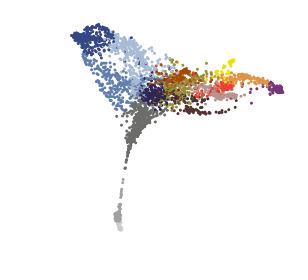

In [14]:
# Plot spring plot
plt.figure(figsize=(2,2))
vcy.scatter_viz(vlm.ca['spring_x_control'], vlm.ca['spring_y_control'],c=vlm.colorandum, s=2,lw=0)
plt.axis("off");

1 27998


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


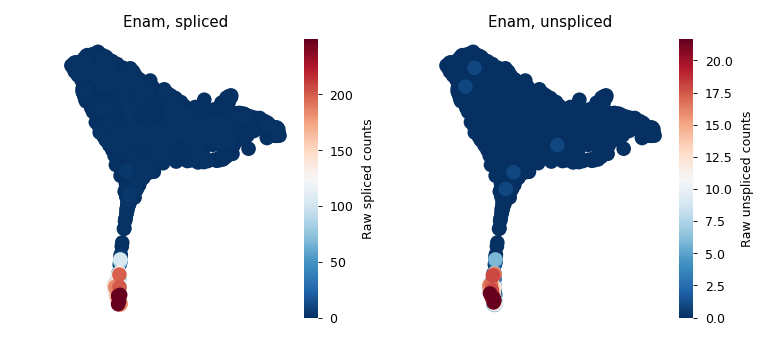

In [15]:
# confirm that SPRING xy coordinates are in-frame with expression values (i.e. that barcode order is consistent)

# x and y
x0 = vlm.ca['spring_x_control']
y0 = vlm.ca['spring_y_control']

# select gene to plot
gene = 'Enam'

# select expression value corresponding to gene
gmask = np.in1d(vlm.ra['Gene'],[gene])
print(gmask.sum(),len(gmask))

# gene expression level, spliced and unspliced
sel = vlm.S[gmask,:][0]
uel = vlm.U[gmask,:][0]

# values to colors
saturate_at = 99.9
smax = np.percentile(sel,saturate_at)
umax = np.percentile(uel,saturate_at)

# order in such a way as highest expressors plotted on top
order = np.argsort(sel)
sel = sel[order]
x = x0[order]
y = y0[order]

a,fig,gs = rz.startfig(13,6,columns=2)
scatter = a.scatter(x,y,c=sel,vmin=0,vmax=smax,cmap="RdBu_r")
a.set_title('%s, spliced'%gene)
cbar = fig.colorbar(scatter)
cbar.set_label('Raw spliced counts')
cbar.outline.set_visible(False)
a.axis('off');

a2 = fig.add_subplot(gs[0,1])
# order in such a way as highest expressors plotted on top
order = np.argsort(uel)
uel = uel[order]
x = x0[order]
y = y0[order]

scatter2 = a2.scatter(x,y,c=uel,vmin=0,vmax=umax,cmap="RdBu_r")
a2.set_title('%s, unspliced'%gene)
cbar2 = fig.colorbar(scatter2)
cbar2.set_label('Raw unspliced counts')
cbar2.outline.set_visible(False)
a2.axis('off');

gs.tight_layout(fig)

In [16]:
# create the embedding attribute used downstream
vlm.spring = np.column_stack([vlm.ca['spring_x_control'], vlm.ca['spring_y_control']])

In [17]:
for key,value in vlm.ca.items():
    print(key,type(value[0]))

CellID <class 'numpy.str_'>
simple_bc <class 'numpy.str_'>
used_in_spring <class 'numpy.bool_'>
spring_x_control <class 'numpy.float64'>
spring_y_control <class 'numpy.float64'>
clusters <class 'str'>


In [18]:
# optional = backup to quickly continue from here
#!mkdir -p backups
#vlm.to_hdf5("backups/velocyto_incisor_control_backup")

In [19]:
# From backup
#vlm = vcy.load_velocyto_hdf5("backups/velocyto_incisor_control_backup")

### steps below almost unchanged from https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb

In [20]:
vlm.score_detection_levels(min_expr_counts=5, min_cells_express=4)
vlm.filter_genes(by_detection_levels=True)

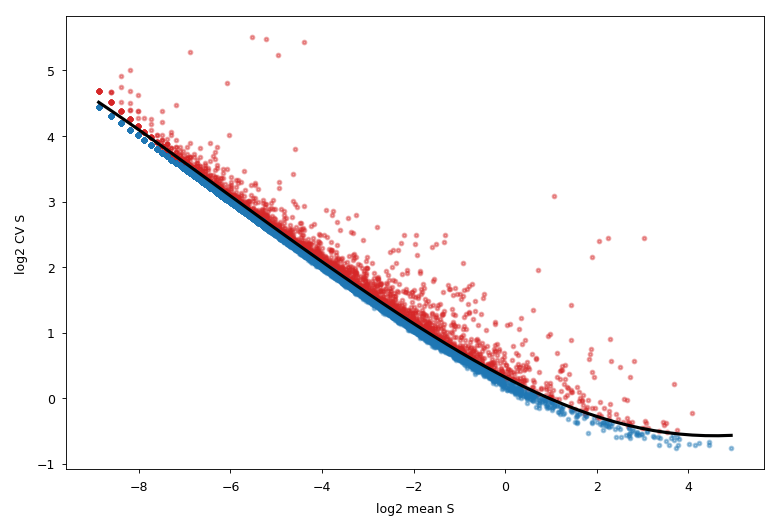

In [21]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [22]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

17


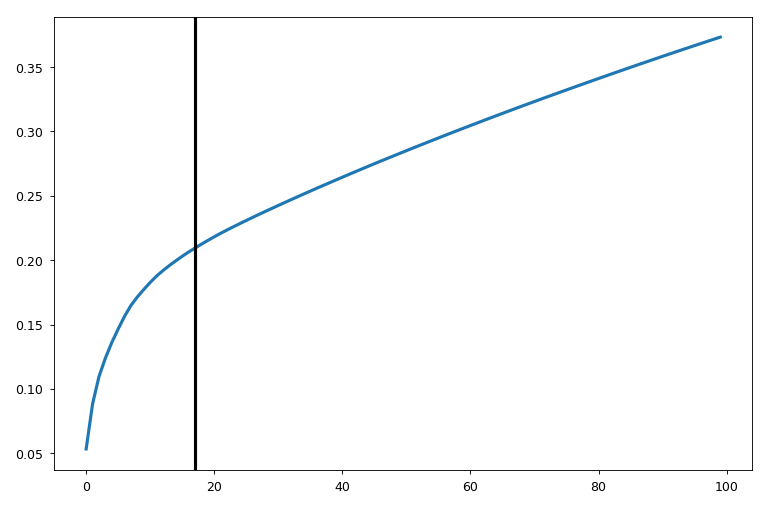

In [23]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])

# this is how component were selected in the example notebook
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.003))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)

In [24]:
k = 60 # essentially default which is 0.024 x N (check documentation help(vlm.knn_imputation))
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

In [25]:
vlm.fit_gammas(limit_gamma=False, fit_offset=False)

vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [26]:
vlm.estimate_transition_prob(hidim="Sx_sz",
                             embed="spring",
                             transform="sqrt",
                             psc=1,
                             knn_random=True,
                             sampled_fraction=1,
                            )

In [27]:
vlm.calculate_embedding_shift(
                              sigma_corr = 0.02,                          
                              expression_scaling=False)

outputs/quiver_control_50_dots_with_arrows


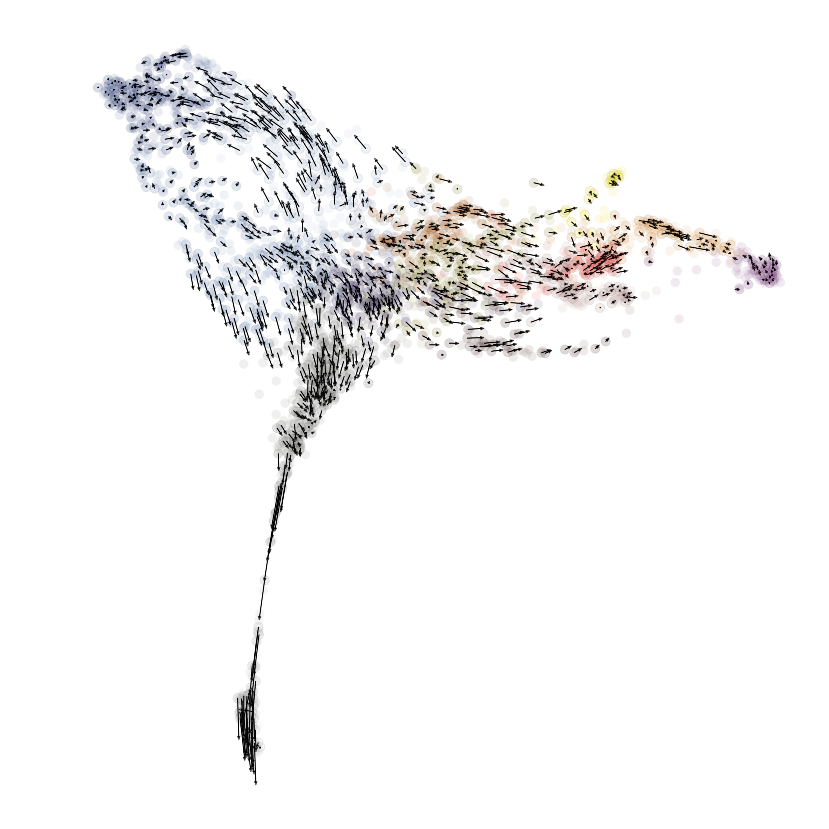

In [28]:
a,fig,gs=rz.startfig(14,14)

quiver_scale = 30

dotsize = 20
pctdots = 50.

a.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c=vlm.colorandum,
            #c = '0.8',
            alpha=.1, s=dotsize, edgecolor="")


ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]*pctdots/100.), replace=False)

# outlines of dots.
a.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c=vlm.colorandum[ix_choice], alpha=0.1, s=dotsize, edgecolor=(0,0,0,1), lw=0.3, rasterized=False)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", 
                   color=vlm.colorandum[ix_choice],
                   alpha=1)

a.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)



a.axis('off')
gs.tight_layout(fig)

savename = 'outputs/quiver_control_%d_dots_with_arrows'%pctdots
print(savename)

#plt.savefig(savename+'.pdf')
#plt.savefig(savename+'.png',dpi=600)

In [29]:
vlm.calculate_grid_arrows(smooth=0.5, steps=(30, 30), n_neighbors=40)

outputs/control_velocity_grid


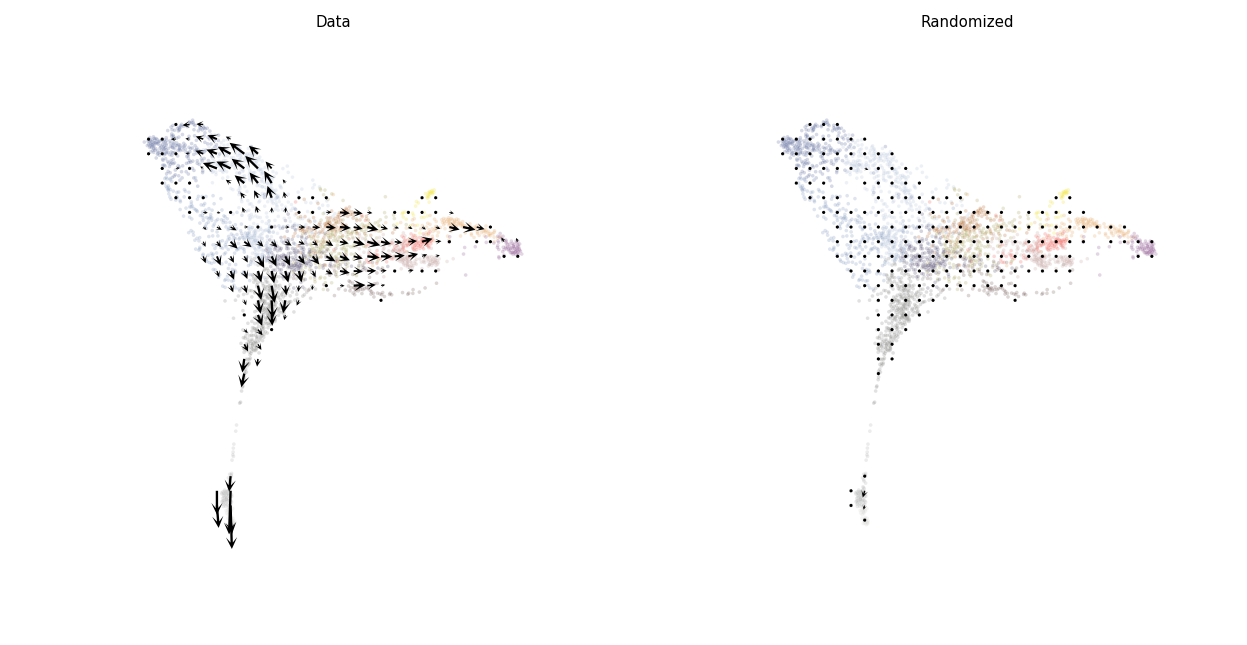

In [30]:
# I need to change margins globally in this notebook for the figure to fit
xmargin_def = mpl.rcParams['axes.xmargin']
ymargin_def = mpl.rcParams['axes.ymargin']
mpl.rcParams['axes.xmargin'] = 0.2
mpl.rcParams['axes.ymargin'] = 0.2


plt.figure(None,(10,5))
plt.scatter((0,0),(-1000,0))

vlm.plot_grid_arrows(quiver_scale='auto',#1.5,#'auto',
                     scatter_kwargs_dict={"alpha":0.2, "lw":0.0, "s":3, "rasterized":False},
                     min_mass=0.2,
                     angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=True,
                    )


savename = 'outputs/control_velocity_grid'
print(savename)

#plt.savefig(savename+'.pdf')
#plt.savefig(savename+'.png',dpi=600)


# margins back to default
mpl.rcParams['axes.xmargin'] = xmargin_def
mpl.rcParams['axes.ymargin'] = ymargin_def